In [1]:
from gridworld_pa1 import world, plot_Q
import numpy as np
from IPython.display import clear_output
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
#same actions are used for plotting the Q value graph
DOWN = 1
UP = 0
LEFT = 2
RIGHT = 3
actions = [DOWN, UP, LEFT, RIGHT]

In [3]:
#choose number 0 to 5 to enter a argument for world number
env  = world(world_num = 1)
print("Number of actions", env.num_actions) #0 -> UP, 1-> DOWN, 2 -> LEFT, 3-> RIGHT
print("Number of states", env.num_states)
print("start state", env.start_state_seq)
print("goal state(s)", env.goal_states_seq)

Number of actions 4
Number of states 100
start state [4]
goal state(s) [ 9 22 87]


### SARSA

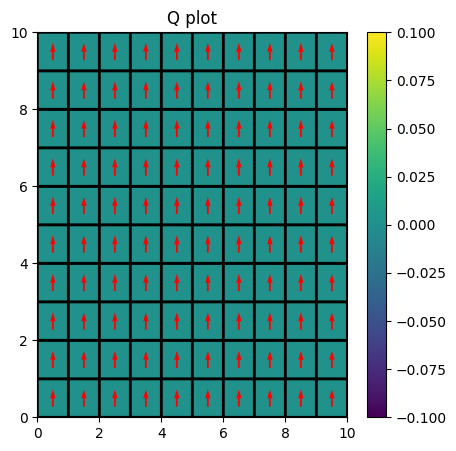

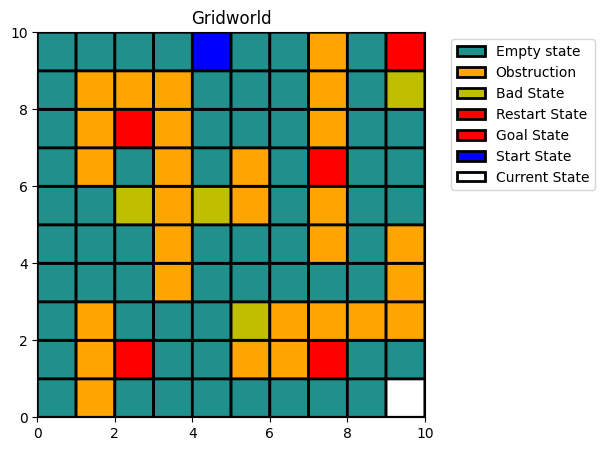

In [4]:
#plot Q value
Q = np.zeros((env.num_states, env.num_actions))


plot_Q(Q)
env.render_world()

### ALGO

In [5]:
from scipy.special import softmax

seed = 42
rg = np.random.RandomState(seed)

# Softmax
def choose_action_softmax(Q, state, rg=rg):
    action_probs = softmax(Q[state])
    return rg.choice(len(actions), p=action_probs)


In [6]:
alpha0 = 0.4
gamma = 0.9
episodes =5000

In [7]:
print_freq = 100
            
def sarsa(env, Q, gamma=0.9, plot_heat=False, choose_action=choose_action_softmax):
    episode_rewards = np.zeros(episodes)
    steps_to_completion = np.zeros(episodes)
    if plot_heat:
        clear_output(wait=True)
        plot_Q(Q)
    alpha = alpha0
    for ep in tqdm(range(episodes)):
        tot_reward, steps = 0, 0
        
        # Reset environment
        state = env.reset()
        action = choose_action(Q, state)
        done = False
        while not done:
            state_next, reward, done = env.step(state, action)
            action_next = choose_action(Q, state_next)
            
            # Update equation for SARSA
            Q[state, action] += alpha * (reward + gamma * Q[state_next, action_next] - Q[state, action])
            
            tot_reward += reward
            steps += 1
            
            state, action = state_next, action_next

            if state in env.goal_states_seq:
                break
        
        episode_rewards[ep] = tot_reward
        steps_to_completion[ep] = steps
        
        if (ep+1) % print_freq == 0 and plot_heat:
            clear_output(wait=True)
            plot_Q(Q, message="Episode %d: Reward: %f, Steps: %.2f, Qmax: %.2f, Qmin: %.2f" % (ep+1, np.mean(episode_rewards[ep-print_freq+1:ep]),
                                                                                             np.mean(steps_to_completion[ep-print_freq+1:ep]),
                                                                                             Q.max(), Q.min()))
                
    return Q, episode_rewards, steps_to_completion

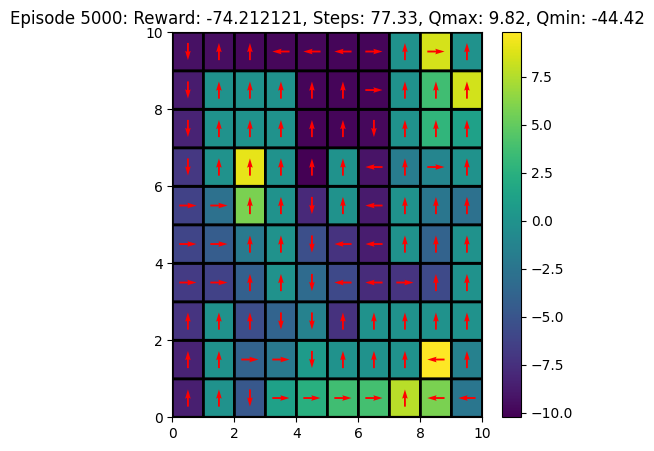

100%|██████████| 5000/5000 [00:22<00:00, 221.50it/s]


In [8]:
Q, rewards, steps = sarsa(env, Q, gamma = gamma, plot_heat=True, choose_action= choose_action_softmax)

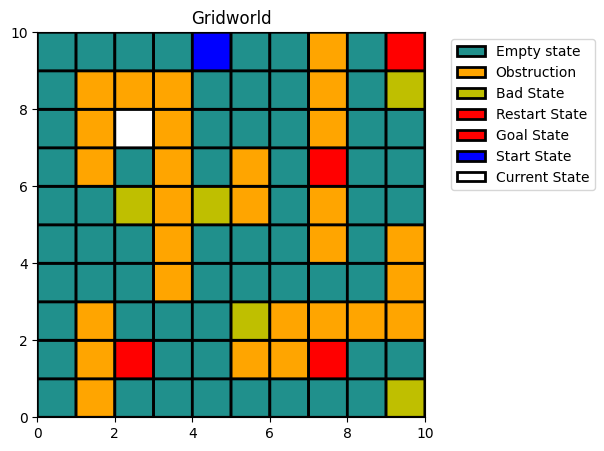

Steps: 21, Total Reward: -4


C:\Users\anike\AppData\Local\Temp\ipykernel_14824\1354543323.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Steps: %d, Total Reward: %d"%(steps, tot_reward))


In [9]:
from time import sleep

state = env.reset()
done = False
steps = 0
tot_reward = 0

while not done:
    clear_output(wait=True)
    state, reward, done= env.step(state,Q[state].argmax())
    env.render_world(state)
    steps += 1
    tot_reward += reward
    sleep(0.2)
print("Steps: %d, Total Reward: %d"%(steps, tot_reward))

Experiment: 1


  0%|          | 0/5000 [00:00<?, ?it/s]C:\Users\anike\AppData\Local\Temp\ipykernel_14824\2250460112.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Q[state, action] += alpha * (reward + gamma * Q[state_next, action_next] - Q[state, action])
C:\Users\anike\AppData\Local\Temp\ipykernel_14824\2250460112.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  episode_rewards[ep] = tot_reward
100%|██████████| 5000/5000 [00:15<00:00, 313.88it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:15<00:00, 318.10it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:15<00:00, 315.11it/s]


Experiment: 4


100%|██████████| 5000/5000 [00:15<00:00, 320.83it/s]


Experiment: 5


100%|██████████| 5000/5000 [00:15<00:00, 320.99it/s]


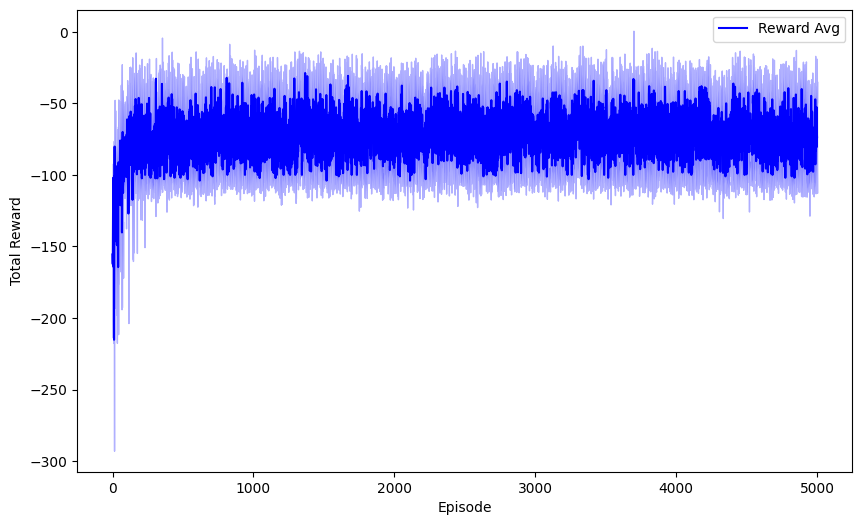

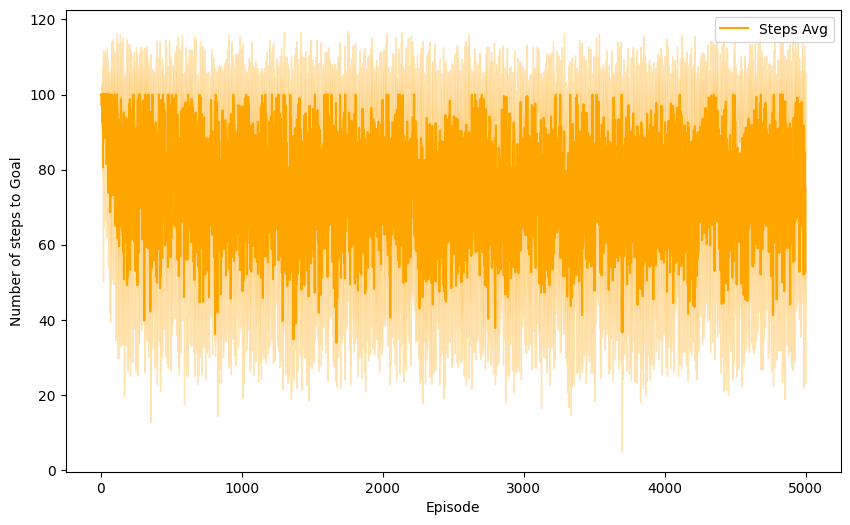

In [10]:
num_expts = 5
reward_avgs = []
steps_avgs =[]

for i in range(num_expts):
    print("Experiment: %d"%(i+1))
    Q = np.zeros((env.num_states, env.num_actions))

    Q, rewards, steps = sarsa(env, Q, gamma=gamma, plot_heat=False, choose_action=choose_action_softmax)
    reward_avgs.append(rewards)
    steps_avgs.append(steps)
    
reward_avgs_mean = np.mean(reward_avgs, axis=0)
reward_avgs_std = np.std(reward_avgs, axis=0)

steps_avgs_mean = np.mean(steps_avgs, axis=0)
steps_avgs_std = np.std(steps_avgs, axis=0)

plt.figure(figsize=(10, 6))

# Plot mean
plt.plot(range(episodes), reward_avgs_mean, label='Reward Avg', color='blue')

# Plot standard deviation as shaded region
plt.fill_between(range(episodes), reward_avgs_mean - reward_avgs_std, reward_avgs_mean + reward_avgs_std, alpha=0.3, color='blue')

plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))

# Plot mean
plt.plot(range(episodes), steps_avgs_mean, label='Steps Avg', color='orange')

# Plot standard deviation as shaded region
plt.fill_between(range(episodes), steps_avgs_mean - steps_avgs_std, steps_avgs_mean + steps_avgs_std, alpha=0.3, color='orange')

plt.xlabel('Episode')
plt.ylabel('Number of steps to Goal')
plt.legend()
plt.show()



### Q-Learning

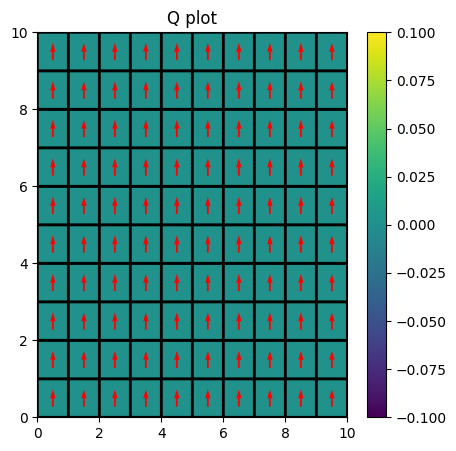

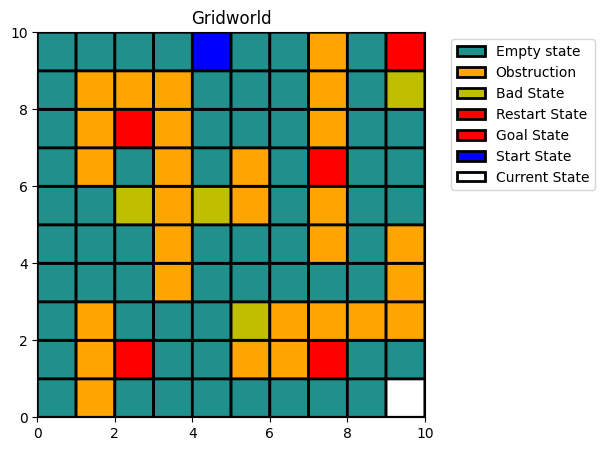

In [11]:
#plot Q value
Q = np.zeros((env.num_states, env.num_actions))

plot_Q(Q)
env.render_world()

In [12]:
print_freq = 100
            
def qlearning(env, Q, gamma=0.9, plot_heat=False, choose_action=choose_action_softmax):
    episode_rewards = np.zeros(episodes)
    steps_to_completion = np.zeros(episodes)
    if plot_heat:
        clear_output(wait=True)
        plot_Q(Q)
    alpha = alpha0
    for ep in tqdm(range(episodes)):
        tot_reward, steps = 0, 0
        
        # Reset environment
        state = env.reset()
        action = choose_action(Q, state)
        done = False
        while not done:
            state_next, reward, done = env.step(state, action)
            action_next = choose_action(Q, state_next)
            
            # Update equation for SARSA
            Q[state, action] += alpha * (reward + gamma * np.max(Q[state_next]) - Q[state, action])
            
            tot_reward += reward
            steps += 1
            
            state, action = state_next, action_next

            if state in env.goal_states_seq:
                break
        
        episode_rewards[ep] = tot_reward
        steps_to_completion[ep] = steps
        
        if (ep+1) % print_freq == 0 and plot_heat:
            clear_output(wait=True)
            plot_Q(Q, message="Episode %d: Reward: %f, Steps: %.2f, Qmax: %.2f, Qmin: %.2f" % (ep+1, np.mean(episode_rewards[ep-print_freq+1:ep]),
                                                                                             np.mean(steps_to_completion[ep-print_freq+1:ep]),
                                                                                             Q.max(), Q.min()))
                
    return Q, episode_rewards, steps_to_completion

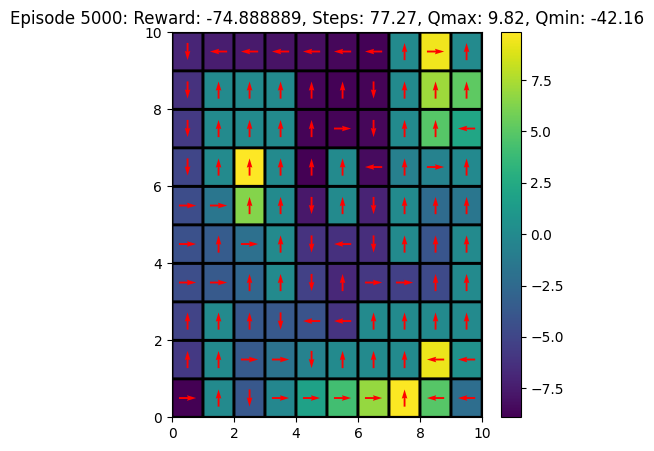

100%|██████████| 5000/5000 [00:23<00:00, 213.18it/s]


In [13]:
Q, rewards, steps = qlearning(env, Q, gamma = gamma, plot_heat=True, choose_action= choose_action_softmax)

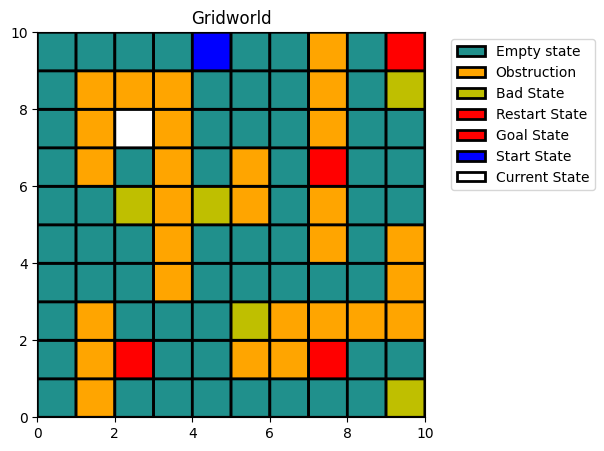

Steps: 17, Total Reward: 0


C:\Users\anike\AppData\Local\Temp\ipykernel_14824\1354543323.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Steps: %d, Total Reward: %d"%(steps, tot_reward))


In [15]:
from time import sleep

state = env.reset()
done = False
steps = 0
tot_reward = 0

while not done:
    clear_output(wait=True)
    state, reward, done= env.step(state,Q[state].argmax())
    env.render_world(state)
    steps += 1
    tot_reward += reward
    sleep(0.2)
print("Steps: %d, Total Reward: %d"%(steps, tot_reward))

Experiment: 1


  0%|          | 0/5000 [00:00<?, ?it/s]C:\Users\anike\AppData\Local\Temp\ipykernel_14824\2250460112.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Q[state, action] += alpha * (reward + gamma * Q[state_next, action_next] - Q[state, action])
C:\Users\anike\AppData\Local\Temp\ipykernel_14824\2250460112.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  episode_rewards[ep] = tot_reward
100%|██████████| 5000/5000 [00:15<00:00, 318.45it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:18<00:00, 274.78it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:17<00:00, 287.95it/s]


Experiment: 4


100%|██████████| 5000/5000 [00:15<00:00, 314.22it/s]


Experiment: 5


100%|██████████| 5000/5000 [00:15<00:00, 312.75it/s]


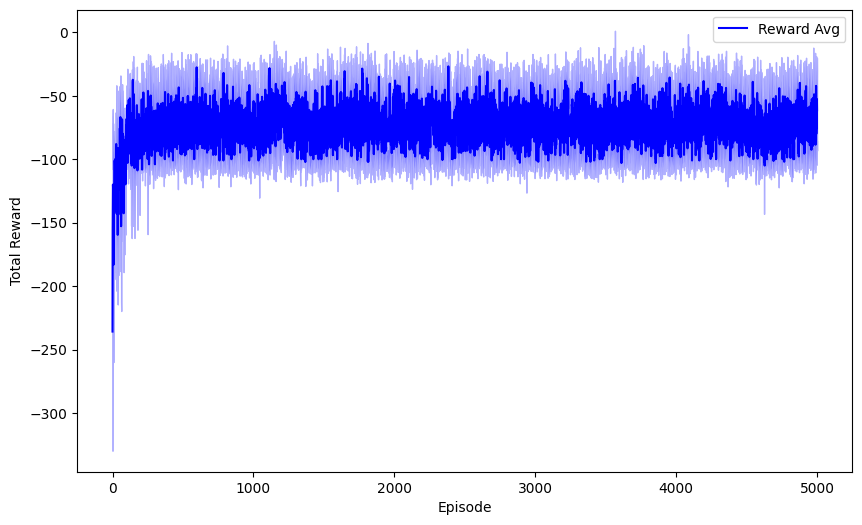

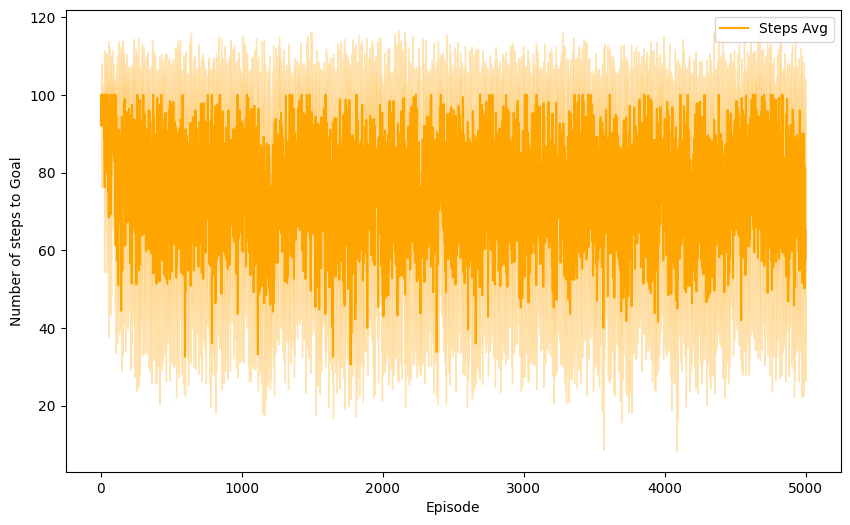

In [16]:
num_expts = 5
reward_avgs = []
steps_avgs =[]

for i in range(num_expts):
    print("Experiment: %d"%(i+1))
    Q = np.zeros((env.num_states, env.num_actions))

    Q, rewards, steps = sarsa(env, Q, gamma=gamma, plot_heat=False, choose_action=choose_action_softmax)
    reward_avgs.append(rewards)
    steps_avgs.append(steps)
    
reward_avgs_mean = np.mean(reward_avgs, axis=0)
reward_avgs_std = np.std(reward_avgs, axis=0)

steps_avgs_mean = np.mean(steps_avgs, axis=0)
steps_avgs_std = np.std(steps_avgs, axis=0)

plt.figure(figsize=(10, 6))

# Plot mean
plt.plot(range(episodes), reward_avgs_mean, label='Reward Avg', color='blue')

# Plot standard deviation as shaded region
plt.fill_between(range(episodes), reward_avgs_mean - reward_avgs_std, reward_avgs_mean + reward_avgs_std, alpha=0.3, color='blue')

plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))

# Plot mean
plt.plot(range(episodes), steps_avgs_mean, label='Steps Avg', color='orange')

# Plot standard deviation as shaded region
plt.fill_between(range(episodes), steps_avgs_mean - steps_avgs_std, steps_avgs_mean + steps_avgs_std, alpha=0.3, color='orange')

plt.xlabel('Episode')
plt.ylabel('Number of steps to Goal')
plt.legend()
plt.show()

